In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20})
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from scipy.sparse.linalg import svds

from surprise import (SVD
                      , SVDpp
                      , SlopeOne
                      , NMF
                      , NormalPredictor
                      , KNNBaseline
                      , KNNBasic
                      , KNNWithMeans
                      , KNNWithZScore
                      , BaselineOnly
                      , CoClustering)
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.split import train_test_split
from surprise.model_selection.validation import cross_validate
from surprise import accuracy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.models import (load_data
                        , data_summary
                        , combine_tables
                        , collab_mat
                        , svd_mat
                        , svd_model
                        , surprise_bench
                        , top_biz_pred
                        , NMF_Mat
                        , NN_Model
                        , NN_Results_df
                        , con_bas_biz_rec
                       )

### Load Data

In [4]:
biz_df, rev_df, ckin_df, pho_df, tip_df, user_df = load_data()

In [5]:
data_summary(biz_df
             , rev_df
             , ckin_df
             , pho_df
             , tip_df
             , user_df)

name,rows,colums
business,192609,14
review,6685900,9
checkin,161950,2
photo,200000,4
tip,1223094,5
user,1637138,22


In [6]:
user_rev_biz = combine_tables(user_df
                              , rev_df
                              , biz_df)

In [7]:
user_rev_biz.city.value_counts()[0:5]

Las Vegas     1757375
Phoenix        645716
Toronto        434349
Scottsdale     329826
Charlotte      273989
Name: city, dtype: int64

In [8]:
user_biz_collab_mat = collab_mat('Scottsdale'
                                 , user_rev_biz)

In [9]:
user_biz_collab_mat.shape

(140940, 7081)

### SVD

In [10]:
sigma, user_biz_predictions = svd_mat(user_biz_collab_mat, k=40)

### Precictions

In [11]:
top_biz_pred('--2HUmLkcNHZp0xw6AMBPg'
             , df_all = user_rev_biz
             , df_mat = user_biz_collab_mat
             , df_pred = user_biz_predictions
             , n=5)

('Kristin',
 ['True Food Kitchen',
  'Cafe Monarch',
  'The Herb Box',
  'Sweet Republic',
  'Talking Stick Resort'])

In [12]:
user_rev_biz['biz_name'].loc[user_rev_biz.user_id == '--2HUmLkcNHZp0xw6AMBPg'][0:5]

3360      Butters Pancakes & Café
312378                 Wildflower
600627               Flower Child
624904               Viet Kitchen
744479                 Wildflower
Name: biz_name, dtype: object

### Validation

In [13]:
data, svd_acc, svd_cv = svd_model(df = user_rev_biz)

RMSE: 0.7047


In [14]:
svd_acc

0.704676106912347

In [15]:
svd_cv

array([0.70154216, 0.69816876, 0.70262592, 0.69853971, 0.69720105])

In [16]:
bench_df = surprise_bench(df=user_rev_biz)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [17]:
bench_df

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
NMF,0.638938,0.403448,21.671024,0.707609
SVDpp,0.681448,0.461397,49.620264,1.736770
SVD,0.699552,0.489586,13.361957,0.624362
BaselineOnly,0.718242,0.509594,1.837605,0.593725
NormalPredictor,1.102951,0.867716,0.528350,0.667730


### NMF

In [18]:
NMF_results = cross_validate(NMF(), data, cv = 5)

In [19]:
NMF_results['test_rmse']

array([0.63540654, 0.63793109, 0.64300185, 0.64204167, 0.64038207])

In [20]:
from sklearn.decomposition import NMF

In [21]:
nmf_mat = NMF_Mat(user_biz_collab_mat)

In [22]:
top_biz_pred('--2HUmLkcNHZp0xw6AMBPg'
             , df_all = user_rev_biz
             , df_mat = user_biz_collab_mat
             , df_pred = nmf_mat
             , n=5)

('Kristin',
 ['True Food Kitchen',
  'North Italia',
  "Portillo's Hot Dogs",
  "Mastro's Ocean Club",
  'Sweet Republic'])

In [23]:
user_rev_biz['biz_name'].loc[user_rev_biz.user_id == '--2HUmLkcNHZp0xw6AMBPg'][0:10]

3360        Butters Pancakes & Café
312378                   Wildflower
600627                 Flower Child
624904                 Viet Kitchen
744479                   Wildflower
746301     Original Breakfast House
771054      Andreoli Italian Grocer
838710                 Barrio Queen
1147492        Rocket Burger & Subs
1155989                 Rustic Cafe
Name: biz_name, dtype: object

### Neural Network Predictor (Recommender???)



In [24]:
# Source: https://www.youtube.com/watch?v=4vwNkHFuZBk

In [25]:
from tensorflow.keras.layers import (Input
                                     , Embedding
                                     , Dot
                                     , Flatten
                                    )
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import Callback

import os

In [26]:
X_test, model, history = NN_Model(df = user_rev_biz
                                 , n_factors = 5
                                 , ep = 16)


Testing loss: 14.257628291370043, acc: 0.0


Testing loss: 11.043365735690905, acc: 0.0002425506681902334


Testing loss: 9.064130306585085, acc: 0.0008489273022860289


Testing loss: 7.851060826355367, acc: 0.0012612635036930442


Testing loss: 7.082931885806678, acc: 0.001491686562076211


Testing loss: 6.5866060142226095, acc: 0.0015523242764174938


Testing loss: 6.251445790087311, acc: 0.0016129618743434548


Testing loss: 6.0205780349644105, acc: 0.0016735995886847377


Testing loss: 5.863355980989031, acc: 0.0017099821707233787


Testing loss: 5.7603639446200114, acc: 0.0016735995886847377


Testing loss: 5.687431131129264, acc: 0.0016735995886847377


Testing loss: 5.636232532507605, acc: 0.0017099821707233787


Testing loss: 5.598479122356077, acc: 0.0016857271548360586


Testing loss: 5.571781806555342, acc: 0.0016978546045720577


Testing loss: 5.550388453481141, acc: 0.0016857271548360586


Testing loss: 5.5355299876400315, acc: 0.0017342371866106987

Instructions for upda

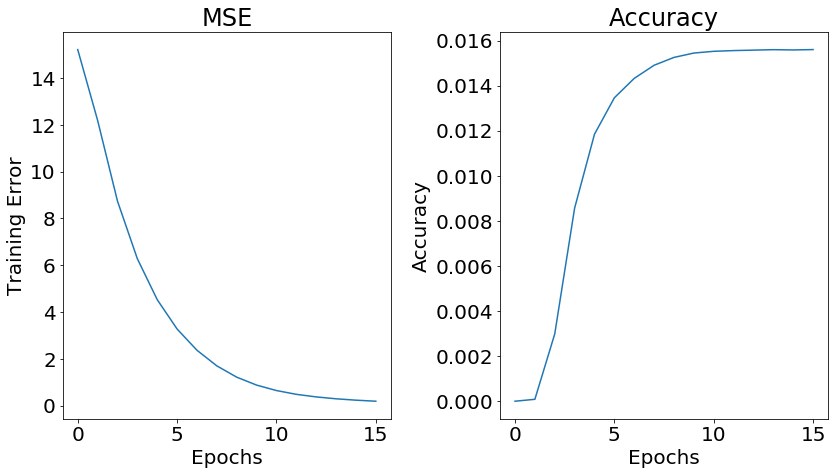

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12,7), tight_layout=True)
ax[0].plot(history.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Error')
ax[0].set_title('MSE')
    
ax[1].plot(history.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy');

In [28]:
NN_Results_df(mod = model
             , xtest = X_test
             , n=15)

,user_name,biz_name,average_stars,Prediction
1600473,Mirco,Merci French Cafe & Patisserie,4.81,4.678542
773319,Scott,McCormick-Stillman Railroad Park,3.62,3.595430
2675092,Ashley,Zoes Kitchen,4.11,4.583051
3141992,Dawn,Scottsdale Nails,4.70,4.824436
2063207,Shaila,Saints & Scissors Salon,4.71,0.167454
3693030,Shaya,Persian Room,4.06,4.053452
6037906,Marnie,Sir Grout Phoenix,3.75,-0.039038
1878741,Chelsea,Houston's Restaurant,4.25,4.186199
4351605,Horace,Nekter Juice Bar,4.75,4.830664
4458509,Stephanie,Blue Adobe Santa Fe Grille,3.75,3.496250


### Using Texts to Model Business to Business Similarity

In [29]:
con_bas_biz_rec(df = user_rev_biz, n = 5)

,name,rating
0,"Ferguson Bath, Kitchen & Lighting Gallery",0.516044
1,Scottsdale Rooter Plumbers,0.423362
2,Troon North Custom Tailor,0.421407
3,The Flower Cart,0.419961
4,Gainey Fabricare Cleaners,0.418511
